In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
from MDAnalysis.analysis.rms import RMSD
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ref_traj = '/home/annika/md_sims/official_extraction/20_ns_sims_new/end_20ns.pdb'
new_traj_file = '/home/annika/md_sims/official_extraction/20_ns_sims_new/adding_new_wrap_superimposition_20.dcd'

In [3]:
u_ref = mda.Universe(ref_traj, new_traj_file)

/home/annika/miniconda3/envs/mdanalysis/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [4]:
rmsd_list = []
bb = u_ref.select_atoms("protein")
print(type(bb))
for i in range(len(u_ref.trajectory)):
    u_ref.trajectory[i]
    A = bb.positions.copy()  # coordinates of first frame
    u_ref.trajectory[-1]         # forward to last frame
    B = bb.positions.copy()  # coordinates of last frame
    rmsd_list.append(rms.rmsd(A, B))

<class 'MDAnalysis.core.groups.AtomGroup'>


In [5]:
# Extract RMSD values and timesteps
# rmsd_values = rmsd_analysis.rmsd[:, 2]  # Third column contains the RMSD values
# print(rmsd_values.shape)
rmsd_values = np.asarray(rmsd_list)
timesteps = np.arange(len(rmsd_list)) * 0.0002

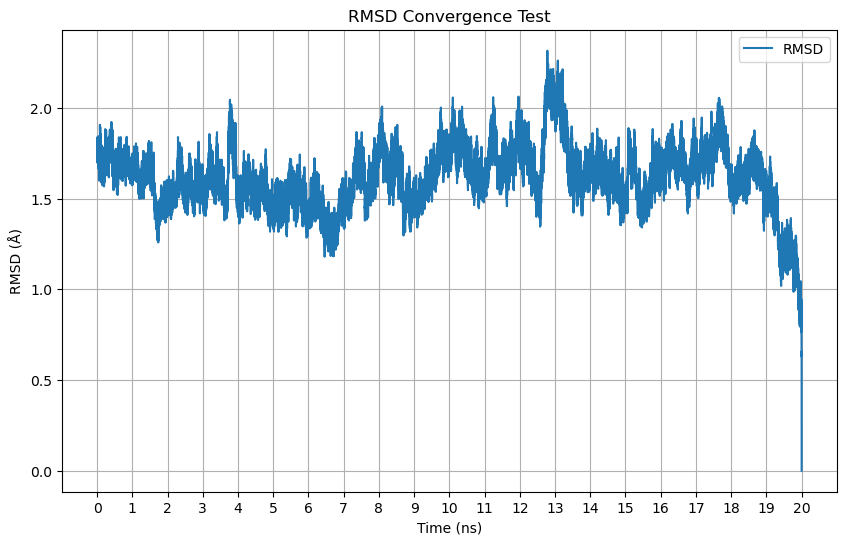

In [21]:
# Plot RMSD values
plt.figure(figsize=(10, 6))
plt.plot(timesteps, rmsd_values, label="RMSD")
plt.xticks(np.arange(min(timesteps), max(timesteps)+1, 1.0))
plt.xlabel("Time (ns)")
plt.ylabel("RMSD (Å)")
plt.title("RMSD Convergence Test")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
avg_rmsd_vals = np.zeros((100000,))
def obtain_avg_rmsd_values(rmsd_vals, avg_rmsd_values, ts_interval):
    index = 0
    step_range = int(avg_rmsd_values.shape[0] / ts_interval)
    for i in range(step_range):
        temp_val = ts_interval * (i + 1)
        another_temp_val = ts_interval * i
        mean_rmsd = np.mean(rmsd_vals[index:temp_val])
        for i in range(ts_interval):
            avg_rmsd_values[another_temp_val + i] = mean_rmsd
        index += ts_interval

In [23]:
def plot_rolling_mean_rmsd_plot(rmsd_vals, avg_rmsd_val, ts_interval):
    obtain_avg_rmsd_values(rmsd_vals, avg_rmsd_val, ts_interval)
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, avg_rmsd_val, label="RMSD")
    plt.xlabel("Time (ns)")
    plt.xticks(np.arange(min(timesteps), max(timesteps)+1, 1.0))
    plt.ylabel("Mean RMSD (Å)")
    plt.title(f"20 ns Rolling Mean RMSD Convergence Test after every {ts_interval} steps")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/home/annika/md_sims/official_extraction/convergence_plots_20ns/rmsd_20ns_converge_{ts_interval}_frames.png")

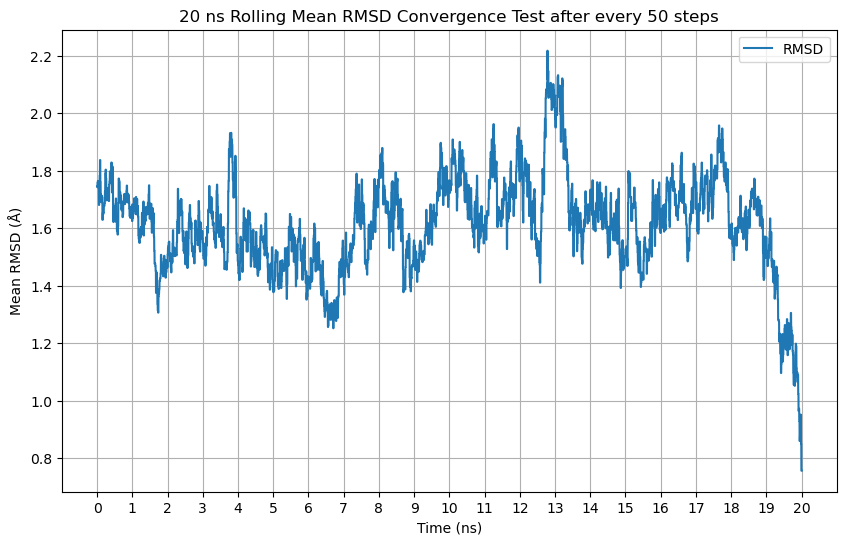

In [24]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 50)

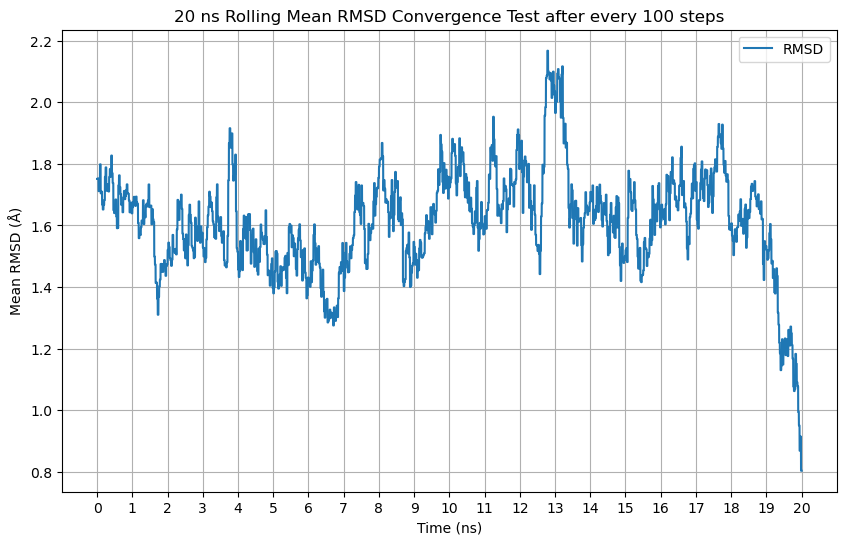

In [25]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 100)

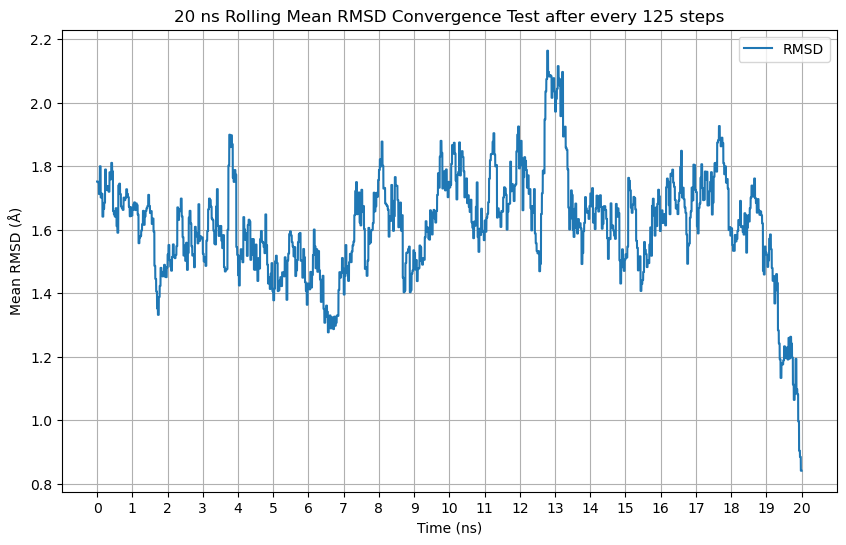

In [26]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 125)

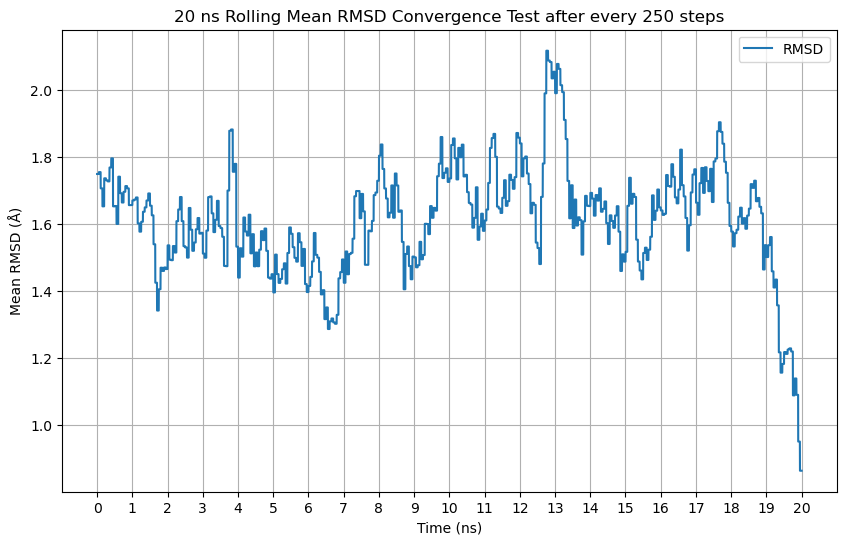

In [27]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 250)

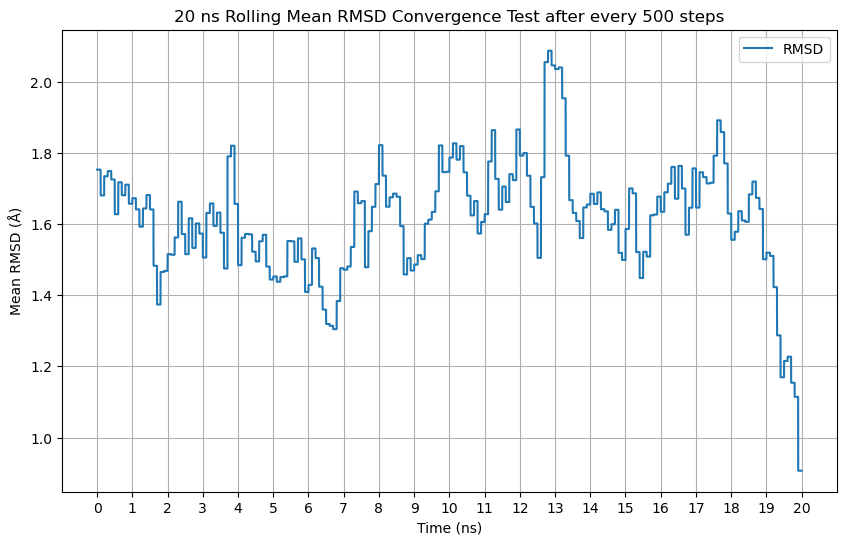

In [28]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 500)

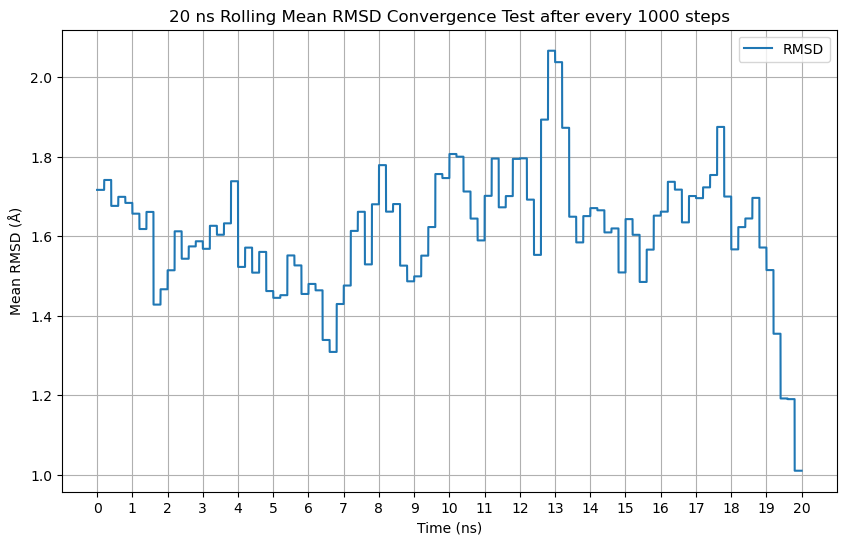

In [29]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 1000)

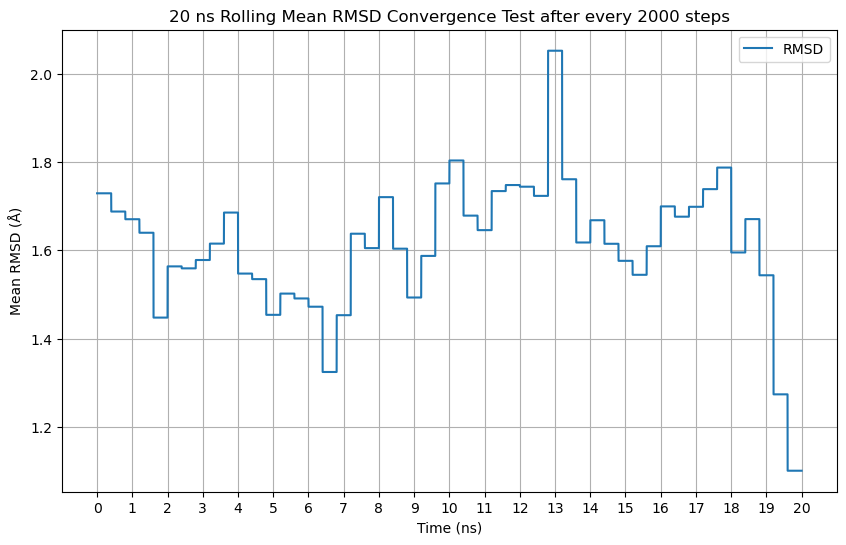

In [30]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 2000)

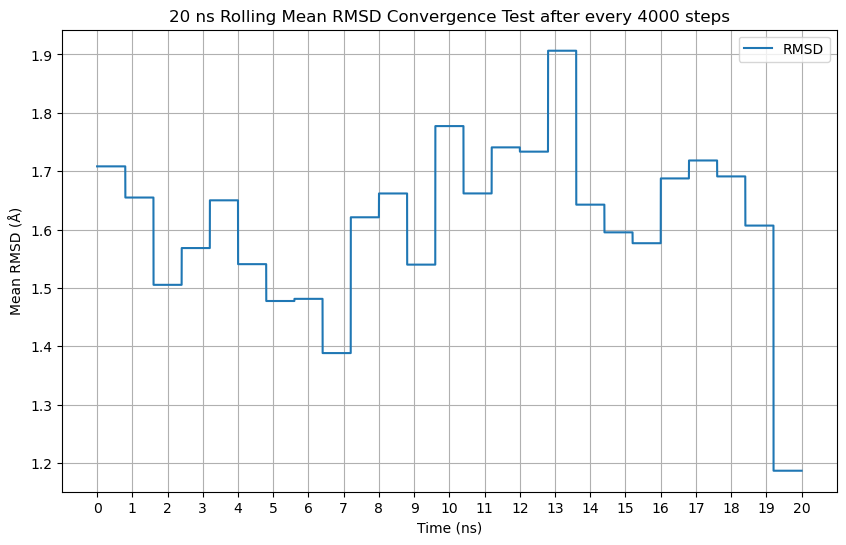

In [31]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 4000)

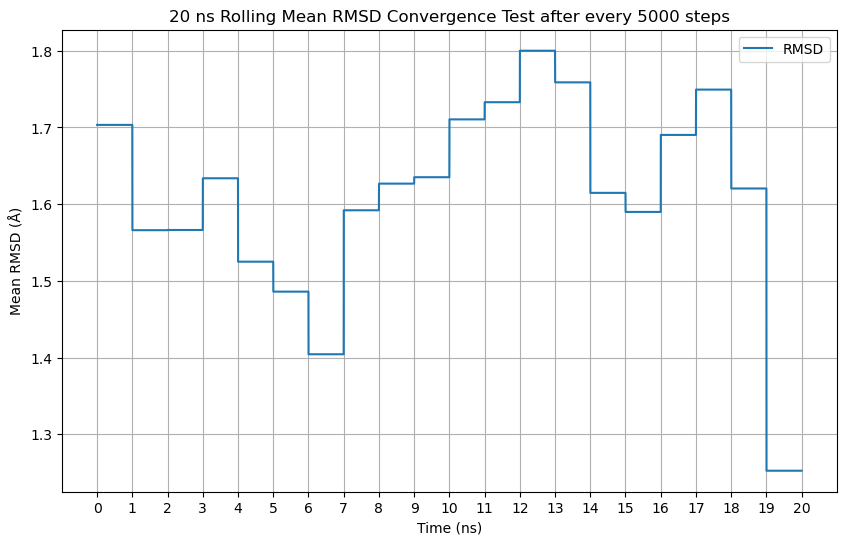

In [32]:
plot_rolling_mean_rmsd_plot(rmsd_values, avg_rmsd_vals, 5000)

In [6]:
from collections import Counter
def create_frequency_dict(state_list):
    frequency_counter = Counter(state_list)
    frequency_dict = dict(frequency_counter)
    for key in frequency_dict.keys():
        probability_value = frequency_dict.get(
            key)/(len(state_list))
        probability_entry = {key: probability_value}
        frequency_dict.update(probability_entry)
    return frequency_dict

In [7]:
def calculate_entropy(freq_dict):
    entropy_value = 0
    for key in freq_dict:
        p_xi = freq_dict.get(key)
        entropy_value += (p_xi * np.log(p_xi))
    return abs(entropy_value)

In [8]:
def plot_entropy_vals(res_num, res_frame, ts_interval):
    state_cols = res_frame[' Entropy State']
    state_array = list(state_cols.to_numpy())
    final_state_array = []
    entropy_list = []
    for i in range(len(state_array)):
        if (i + 1) % ts_interval == 0:
            final_state_array.append(state_array[i])
            frequency_dict = create_frequency_dict(final_state_array)
            entropy = calculate_entropy(frequency_dict)
            entropy_list.append(entropy)
    index = 0
    step_range = int(len(state_array) / ts_interval)
    real_entropy_vals = np.empty((len(state_array),))
    for i in range(step_range):
        another_temp_val = ts_interval * i
        for j in range(ts_interval):
            real_entropy_vals[another_temp_val + j] = entropy_list[i]
        index += ts_interval
    plt.figure()
    plt.title(f"Entropy for Residue {res_num} Collected after every {ts_interval} timestep for 20 ns")
    plt.plot(timesteps, real_entropy_vals, label="Entropy")
    plt.yticks(np.arange(min(real_entropy_vals), max(real_entropy_vals)+1, 0.4), fontsize=8)
    plt.xlabel("Time (ns)")
    plt.ylabel("Entropy value")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/home/annika/md_sims/official_extraction/convergence_plots_20ns/entropy_20ns_{res_num}_converge_{ts_interval}_frames.png")

In [11]:
res_list = [i for i in range(1, 2)]
print(res_list)
time_dep_frame = pd.read_csv('/home/annika/md_sims/official_extraction/convergence_values_20_9-16.csv')
for i in range(len(res_list)):
    res_num = res_list[i] + 0.0
    residue_frame = time_dep_frame[time_dep_frame['# Residue'] == res_num]
    plot_entropy_vals(res_list[i], residue_frame, 1)
    plot_entropy_vals(res_list[i], residue_frame, 125)
    # plot_entropy_vals(res_list[i], residue_frame, 250)
    # plot_entropy_vals(res_list[i], residue_frame, 500)
    # plot_entropy_vals(res_list[i], residue_frame, 1000)
    # plot_entropy_vals(res_list[i], residue_frame, 1250)
    # plot_entropy_vals(res_list[i], residue_frame, 2000)
    # plot_entropy_vals(res_list[i], residue_frame, 4000)
    # plot_entropy_vals(res_list[i], residue_frame, 5000)


[1]


KeyboardInterrupt: 

In [9]:
time_dep_frame = pd.read_csv('/home/annika/md_sims/official_extraction/convergence_values_20_9-16.csv')
res_frame = time_dep_frame[time_dep_frame['# Residue'] == 10.0]
res_frame[' Radius of Gyration']

100000    10.670974
100001    10.659440
100002    10.683599
100003    10.656379
100004    10.577423
            ...    
199995    10.692265
199996    10.733487
199997    10.742303
199998    10.704241
199999    10.647654
Name:  Radius of Gyration, Length: 100000, dtype: float64

In [10]:
def plot_rolling_entropy(window_interval, step_time, res_num):
    # window interval - ex. 1 ns
    # step_time - collect every 0.1 ns at 1 ns time intervals.
    global rmsd_list
    x_points_list = []
    entropy_vals_list = []
    res_num = res_num + 0.0
    res_frame = time_dep_frame[time_dep_frame['# Residue'] == res_num]
    interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * window_interval)
    step_time_interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * step_time)
    plt.figure()
    plt.title(f"Rolling entropy for Residue {res_num} Collected after every {window_interval} ns interval for 20 ns")
    for i in range(0, len(rmsd_list) - interval, step_time_interval):
        state_list = list(res_frame[' Entropy State'][i: i + interval])
        freq_dict = create_frequency_dict(state_list)
        print(freq_dict)
        temp_arr = np.arange(len(rmsd_list) + 1) * 0.0002
        temp_ts_list = (np.arange(len(rmsd_list) + 1) * 0.0002)[i: i + interval]
        print(f"The start time is {temp_ts_list[0]} and the end time is {temp_ts_list[-1]}")
        x_point_to_plot = (temp_ts_list[0] + temp_ts_list[-1]) / 2
        entropy_val = calculate_entropy(freq_dict)
        x_points_list.append(x_point_to_plot)
        entropy_vals_list.append(entropy_val)
    full_state_list = list(res_frame[' Entropy State'])
    freq_dict = create_frequency_dict(full_state_list)
    print(freq_dict)
    entire_entropy = np.asarray([calculate_entropy(freq_dict)] * len(rmsd_list))
    entire_ts_list = (np.arange(len(rmsd_list)) * 0.0002)
    plt.plot(x_points_list, entropy_vals_list, color='red', marker='o', markerfacecolor='blue', markersize=3) 
    plt.plot(entire_ts_list, entire_entropy, color="green")
    plt.grid(True)
    plt.xlabel("Time (ns)")
    plt.ylabel("Entropy value")
    plt.savefig(f"/home/annika/md_sims/official_extraction/rolling_entropy_20ns/entropy_20ns_{res_num}_{step_time}_{window_interval}_frames.png")

{8.0: 0.26184, 7.0: 0.08258, 4.0: 0.3057, 5.0: 0.1289, 6.0: 0.12044, 3.0: 0.10054}
The start time is 0.0 and the end time is 9.9998
{8.0: 0.25984, 7.0: 0.08458, 4.0: 0.3057, 5.0: 0.1289, 6.0: 0.12044, 3.0: 0.10054}
The start time is 0.02 and the end time is 10.0198
{4.0: 0.30568, 7.0: 0.08574, 5.0: 0.1289, 8.0: 0.2587, 6.0: 0.12044, 3.0: 0.10054}
The start time is 0.04 and the end time is 10.0398
{7.0: 0.08632, 4.0: 0.305, 5.0: 0.1289, 8.0: 0.2588, 6.0: 0.12044, 3.0: 0.10054}
The start time is 0.060000000000000005 and the end time is 10.059800000000001
{4.0: 0.30406, 5.0: 0.1289, 7.0: 0.0868, 8.0: 0.25926, 6.0: 0.12044, 3.0: 0.10054}
The start time is 0.08 and the end time is 10.0798
{4.0: 0.30238, 7.0: 0.08856, 8.0: 0.25926, 6.0: 0.12044, 3.0: 0.10054, 5.0: 0.12882}
The start time is 0.1 and the end time is 10.0998
{4.0: 0.30038, 7.0: 0.0905, 8.0: 0.25932, 6.0: 0.12044, 3.0: 0.10054, 5.0: 0.12882}
The start time is 0.12000000000000001 and the end time is 10.1198
{7.0: 0.09162, 8.0: 0.

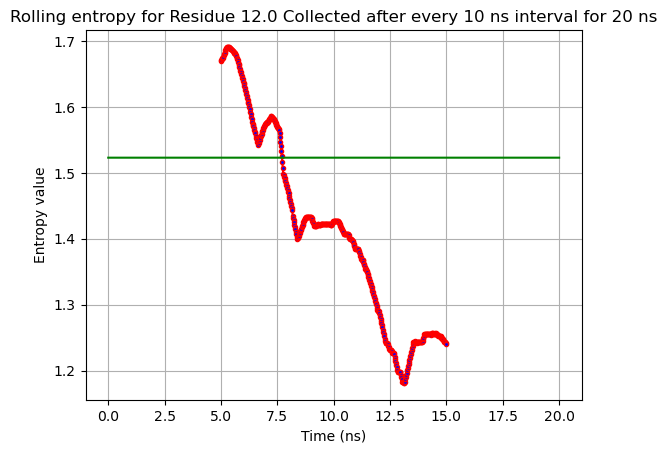

In [14]:
# Entropy flucutates significantly, why is that? Should we also plot radius of gyration.
plot_rolling_entropy(10, 0.02, 12)

In [30]:
def calculate_scaled_entropy(freq_dict):
    # Entropy calculation working correctly.
    entropy_value = 0
    num_states = len(freq_dict)
    for key in freq_dict:
        p_xi = freq_dict.get(key)
        try:
            print(f"p_xi is {p_xi}, log is {np.log(p_xi)}, and number of states is {num_states}")
            entropy_value += (p_xi * np.log(p_xi)) / np.log(num_states)
            print(f"Adding {(p_xi * np.log(p_xi)) / np.log(num_states)} to the current entropy value.")
            print(f"The current entropy value is {entropy_value}")
        except:
            entropy_value += 0.0
    return abs(entropy_value)

In [41]:
def plot_scaled_rolling_entropy(window_interval, step_time, res_num):
    # window interval - ex. 1 ns
    # step_time - collect every 0.1 ns at 1 ns time intervals.
    global rmsd_list
    x_points_list = []
    entropy_vals_list = []
    res_num = res_num + 0.0
    res_frame = time_dep_frame[time_dep_frame['# Residue'] == res_num]
    interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * window_interval)
    step_time_interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * step_time)
    plt.figure()
    plt.title(f"Scaled rolling entropy for Residue {res_num} Collected after every {window_interval} ns interval for 20 ns")
    for i in range(0, len(rmsd_list) - interval, step_time_interval):
        state_list = list(res_frame[' Entropy State'][i: i + interval])
        freq_dict = create_frequency_dict(state_list)
        print(freq_dict)
        temp_ts_list = (np.arange(len(rmsd_list)) * 0.0002)[i: i + interval]
        x_point_to_plot = (temp_ts_list[0] + temp_ts_list[-1]) / 2
        entropy_val = calculate_scaled_entropy(freq_dict)
        x_points_list.append(x_point_to_plot)
        entropy_vals_list.append(entropy_val)
    full_state_list = list(res_frame[' Entropy State'])
    freq_dict = create_frequency_dict(full_state_list)
    entire_entropy = np.asarray([calculate_scaled_entropy(freq_dict)] * len(rmsd_list))
    entire_ts_list = (np.arange(len(rmsd_list)) * 0.0002)
    plt.plot(x_points_list, entropy_vals_list, color='red', marker='o', markerfacecolor='blue', markersize=3) 
    plt.plot(entire_ts_list, entire_entropy, color="green", label="Scaled Shannon entropy")
    plt.grid(True)
    plt.xlabel("Time (ns)")
    plt.ylabel("Entropy value")
    plt.legend()
    plt.savefig(f"/home/annika/md_sims/official_extraction/rolling_entropy_20ns/entropy_scaled_20ns_{res_num}_{step_time}_{window_interval}_frames.png")

{4.0: 0.08308, 3.0: 0.05356, 5.0: 0.34454, 8.0: 0.15464, 7.0: 0.20578, 6.0: 0.1584}
p_xi is 0.08308, log is -2.4879512799742254, and number of states is 6
Adding -0.11536090412253322 to the current entropy value.
The current entropy value is -0.11536090412253322
p_xi is 0.05356, log is -2.9269527581591652, and number of states is 6
Adding -0.08749365772546758 to the current entropy value.
The current entropy value is -0.2028545618480008
p_xi is 0.34454, log is -1.0655450849639139, and number of states is 6
Adding -0.20489519373470075 to the current entropy value.
The current entropy value is -0.40774975558270155
p_xi is 0.15464, log is -1.8666554440820615, and number of states is 6
Adding -0.1611039890288474 to the current entropy value.
The current entropy value is -0.5688537446115489
p_xi is 0.20578, log is -1.5809476420344728, and number of states is 6
Adding -0.18156868227296985 to the current entropy value.
The current entropy value is -0.7504224268845188
p_xi is 0.1584, log is -1

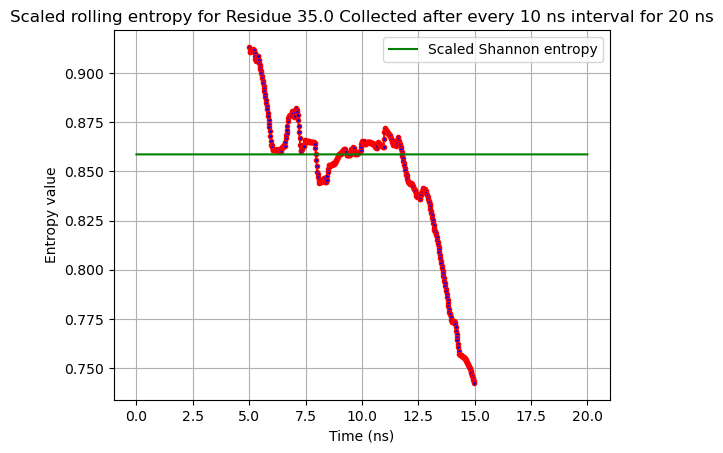

In [46]:
plot_scaled_rolling_entropy(10, 0.02, 35)

In [51]:
plot_scaled_rolling_entropy(7.5, 0.02, 35)

NameError: name 'plot_scaled_rolling_entropy' is not defined

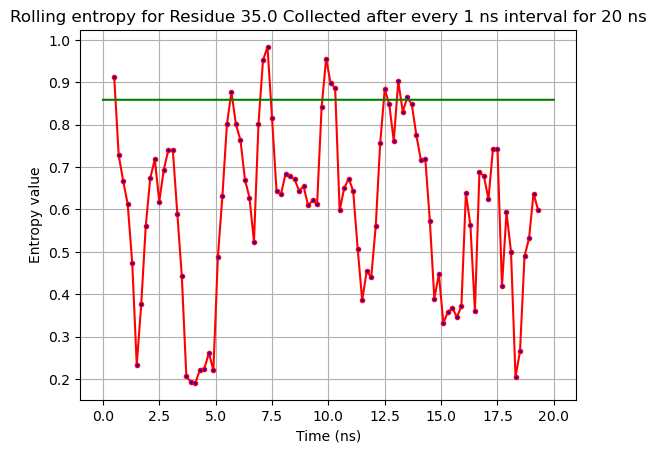

In [119]:
plot_scaled_rolling_entropy(1, 0.2, 35)

In [55]:
def plot_rolling_gyration(window_interval, step_time, res_num):
    # window interval - ex. 1 ns
    # step_time - collect every 0.1 ns at 1 ns time intervals.
    global rmsd_list
    x_points_list = []
    print(len(x_points_list))
    gyration_list = []
    res_num = res_num + 0.0
    res_frame = time_dep_frame[time_dep_frame['# Residue'] == res_num]
    interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * window_interval)
    step_time_interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * step_time)
    plt.figure()
    plt.title(f"Rolling radius of gyration collected after every {window_interval} ns interval for 20 ns")
    for i in range(0, len(rmsd_list) - interval, step_time_interval):
        gyration_vals = list(res_frame[' Radius of Gyration'][i: i + interval])
        mean_gyration_vals = np.mean(gyration_vals)
        temp_ts_list = (np.arange(len(rmsd_list)) * 0.0002)[i: i + interval]
        x_point_to_plot = (temp_ts_list[0] + temp_ts_list[-1]) / 2
        x_points_list.append(x_point_to_plot)
        gyration_list.append(mean_gyration_vals)
    full_state_list = np.asarray(list(res_frame[' Radius of Gyration']))
    mean_gyration_all = [np.mean(full_state_list)] * len(rmsd_list)
    entire_ts_list = (np.arange(len(rmsd_list)) * 0.0002)
    plt.plot(x_points_list, gyration_list, color='red', marker='o', markerfacecolor='blue', markersize=3) 
    plt.plot(entire_ts_list, mean_gyration_all, color="green")
    plt.grid(True)
    plt.xlabel("Time (ns)")
    plt.ylabel("Radius of Gyration (nm)")
    plt.savefig(f"/home/annika/md_sims/official_extraction/rolling_gyration_20ns/rad_gyration_scaled_20ns_{res_num}_{step_time}_{window_interval}_frames.png")
    

0


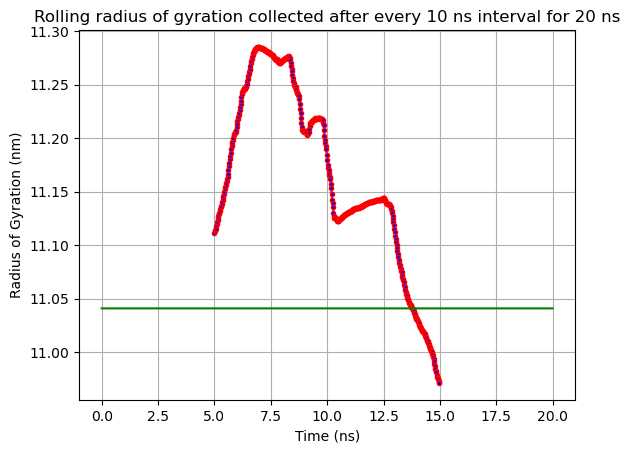

In [56]:
plot_rolling_gyration(10, 0.02, 11)

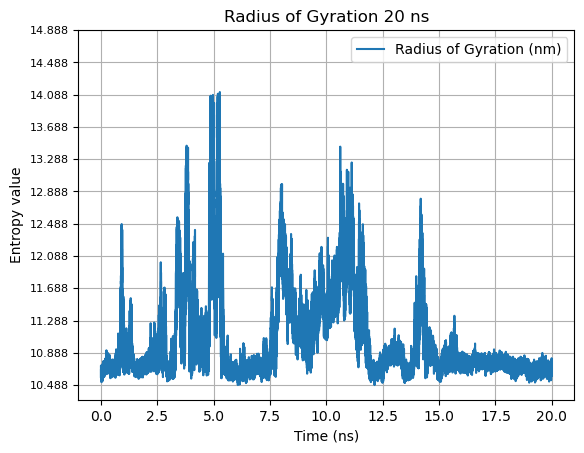

In [60]:
res_frame = time_dep_frame[time_dep_frame['# Residue'] == 11.0]
full_state_list = np.asarray(list(res_frame[' Radius of Gyration']))
plt.figure()
plt.title(f"Radius of Gyration 20 ns")
plt.plot(timesteps, full_state_list, label="Radius of Gyration (nm)")
plt.yticks(np.arange(min(full_state_list), max(full_state_list)+1, 0.4), fontsize=8)
plt.xlabel("Time (ns)")
plt.ylabel("Entropy value")
plt.legend()
plt.grid(True)
plt.savefig(f"/home/annika/md_sims/official_extraction/convergence_plots_20ns/rad_gyration.png")

In [6]:
def plot_rolling_rmsd(window_interval, step_time, res_num):
    # window interval - ex. 1 ns
    # step_time - collect every 0.1 ns at 1 ns time intervals.
    global rmsd_list
    x_points_list = []
    rmsd_values_list = []
    interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * window_interval)
    step_time_interval = int(len(rmsd_list)/(len(rmsd_list)* 0.0002) * step_time)
    plt.figure()
    plt.title(f"Rolling RMSD collected after every {window_interval} ns interval for 20 ns")
    for i in range(0, len(rmsd_list) - interval, step_time_interval):
        rmsd_vals = rmsd_list[i: i + interval]
        mean_gyration_vals = np.mean(rmsd_vals)
        temp_ts_list = (np.arange(len(rmsd_list)) * 0.0002)[i: i + interval]
        x_point_to_plot = (temp_ts_list[0] + temp_ts_list[-1]) / 2
        x_points_list.append(x_point_to_plot)
        rmsd_values_list.append(mean_gyration_vals)
    mean_rmsd = [np.mean(rmsd_list)] * len(rmsd_list)
    entire_ts_list = (np.arange(len(rmsd_list)) * 0.0002)
    plt.plot(x_points_list, rmsd_values_list, color='red', marker='o', markerfacecolor='blue', markersize=3) 
    plt.plot(entire_ts_list, mean_rmsd, color="green")
    plt.grid(True)
    plt.xlabel("Time (ns)")
    plt.ylabel("RMSD")
    plt.savefig(f"/home/annika/md_sims/official_extraction/rolling_rmsd/rmsd_scaled_20ns_{res_num}_{step_time}_{window_interval}_frames.png")
    

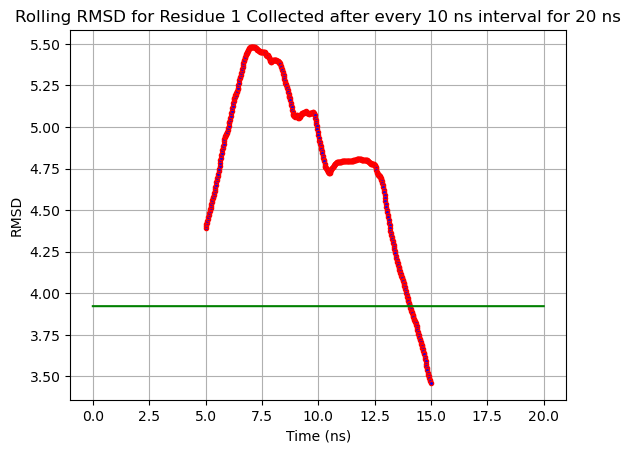

In [12]:
plot_rolling_rmsd(10, 0.02, 1)

In [84]:
# Perform convergence test (same code as before)
def convergence_test(values, threshold=0.1, window_size=10):
    for i in range(window_size, len(values)):
        window_mean = np.mean(values[i - window_size : i])
        if np.abs(window_mean - values[i]) > threshold:
            return False
    return True

In [85]:
# Define convergence parameters
convergence_threshold = 0.1
convergence_window_size = 10

In [86]:
# Perform the convergence test
is_converged = convergence_test(rmsd_values, convergence_threshold, convergence_window_size)

if is_converged:
    print("Convergence achieved.")
else:
    print("Convergence not achieved.")

Convergence not achieved.
